In [28]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
from collections import deque

replay_buffer = deque(maxlen=2000)

input_shape = [4]   # env.observation_space.shape
n_outputs = 5       # env.action_space.n

initializer = tf.keras.initializers.RandomUniform(minval=-0.01, maxval=0.01)

online_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu", kernel_initializer=initializer,
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, kernel_initializer=initializer,
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(n_outputs)
])
# target model is just clone of online model
target_model = tf.keras.models.clone_model(online_model)  # clone the model's architecture
target_model.set_weights(online_model.get_weights())  # copy the weights

2.16.1


In [29]:
def epsilon_greedy_policy(model, state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return np.argmax(Q_values)

def play_one_step(env, model, obs, epsilon, replay_buffer):
    action = epsilon_greedy_policy(model, obs, epsilon)
    actions = {"prisoner": action}
    next_obs, reward, term, trunc, info = env.step(actions)
    next_obs = next_obs["prisoner"] / 10
    reward = reward["prisoner"]
    term = term["prisoner"]
    trunc = trunc["prisoner"]

    replay_buffer.append((obs, action, reward, next_obs, term, trunc))
    
def sample_experiences(replay_buffer, batch_size):
    # print(f"{replay_buffer = }")
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices] # samptling
    n_fields = len(batch[0])
    sample = []
    # "transpose":
    for field_index in range(n_fields): # obs, actions, rewards, next_obs, dones, truncateds
        field_data = []
        for experience in batch:
            field_data.append(experience[field_index])
        sample.append(np.array(field_data))
    return sample  # [obs, actions, rewards, next_obs, dones, truncateds]

def training_step(online_model, target_model, buffer, optimizer, loss_fn, batch_size, discount):
    experiences = sample_experiences(buffer, batch_size)
    obs, actions, rewards, next_obs, terms, truncs = experiences

    next_Q_values = online_model.predict(next_obs, verbose=0)  # ≠ target_model.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target_model.predict(next_obs, verbose = 0) * next_mask
                        ).sum(axis=1)

    runs = 1.0 - (terms | truncs)
    target_Q_values = rewards + runs * discount * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = online_model(obs)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        
        # print(f"{target_Q_values = }, {Q_values = }")

        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        print(f"loss: {float(loss)}")
    grads = tape.gradient(loss, online_model.trainable_variables)
    if float(loss) < 5:
        optimizer.apply_gradients(zip(grads, online_model.trainable_variables))
    else:
        print(f"reject, loss = {float(loss)}")
    

In [30]:
import escape

max_cycles = 152
env = escape.env(render_mode=None, max_cycles=max_cycles)
# env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

batch_size = 16
discount_factor = 0.95
lr = 0.003
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
loss_fn = tf.keras.losses.mse

In [31]:
best_score = 0

for episode in range(600):
    obs, info = env.reset()
    obs = obs["prisoner"] / 10
    rewards = 0
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        play_one_step(env, online_model, obs, epsilon, replay_buffer)

        old_obs, act, reward, obs, term, trunc = replay_buffer[-1]
        rewards += reward
        if term or trunc:
            break

    print(f"\rEpisode: {episode+1}, Steps: {step+1}, eps: {epsilon:.3f} {rewards = :.3f} ", end="")

    if episode > 50:
        training_step(online_model, target_model, replay_buffer, optimizer,
                    loss_fn, batch_size, discount_factor)

    # rewards.append(step)
    # if step >= best_score:
    #     best_weights = model.get_weights()
    #     best_score = step

# model.set_weights(best_weights)

Episode: 52, Steps: 154, eps: 0.898 rewards = -90.427 loss: 4.459138870239258
Episode: 53, Steps: 154, eps: 0.896 rewards = -395.276 loss: 5.016085624694824
reject, loss = 5.016085624694824
Episode: 54, Steps: 154, eps: 0.894 rewards = -383.685 loss: 5.926015853881836
reject, loss = 5.926015853881836
Episode: 55, Steps: 154, eps: 0.892 rewards = 172.280 loss: 5.7874298095703125
reject, loss = 5.7874298095703125
Episode: 56, Steps: 154, eps: 0.890 rewards = -87.611 loss: 4.473961353302002
Episode: 57, Steps: 154, eps: 0.888 rewards = -227.665 loss: 4.321186542510986
Episode: 58, Steps: 154, eps: 0.886 rewards = -87.065 loss: 3.970384120941162
Episode: 59, Steps: 154, eps: 0.884 rewards = -392.993 loss: 3.815354585647583
Episode: 60, Steps: 154, eps: 0.882 rewards = -356.026 loss: 4.214603424072266
Episode: 61, Steps: 154, eps: 0.880 rewards = -261.225 loss: 4.13092565536499
Episode: 62, Steps: 154, eps: 0.878 rewards = -366.782 loss: 3.671363115310669
Episode: 63, Steps: 154, eps: 0.876

KeyboardInterrupt: 

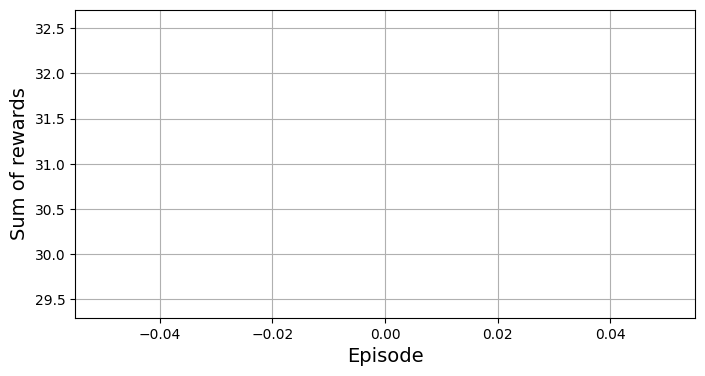

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# @tf.function
def one_step(env, obs, model):
    prisoner_inputs = tf.convert_to_tensor([obs["prisoner"]])
    output = model.predict(prisoner_inputs, verbose=0)
    predicted_action = int(tf.argmax(output, axis=1))

    actions = {"prisoner": predicted_action}
    print(f"\r{actions = } ", end="")
    obs, rewards, term, trunc, infos = env.step(actions)
    return obs, rewards, term, trunc

def play(env, model, loss_fn):
    obs, info = env.reset()
    # obs, info = env.reset(seed=24)
    rewards_list, grads_list = [], []

    while env.agents:
        obs, rew, term, trunc = one_step(env, obs, model)
        rewards_list.append(rew["prisoner"])
        print(f"{rew = }", end="")
    return rewards_list


In [33]:
environment = escape.env(render_mode="human", max_cycles=1500)
r = play(environment, online_model, loss_fn)

actions = {'prisoner': 3} rew = {'prisoner': -1.54937744140625}8}}

KeyboardInterrupt: 

In [34]:
online_model.get_weights()

[array([[-4.28436905e-01, -3.37902725e-01,  1.75262526e-01,
          1.59658149e-01, -3.47845346e-01, -4.24022824e-01,
         -3.23054940e-01, -3.44390690e-01,  1.94203928e-01,
          2.02639088e-01,  1.67316109e-01,  2.08915189e-01,
          1.66561127e-01, -5.13572991e-01, -3.44702214e-01,
         -4.68710601e-01, -3.26345533e-01, -3.29994023e-01,
         -2.70585805e-01,  2.16544166e-01, -3.47773582e-01,
          2.05544785e-01, -3.30572575e-01,  2.97297508e-01,
         -3.36900383e-01,  1.99405923e-01,  1.60992369e-01,
          1.83043361e-01,  2.17266724e-01,  2.04180270e-01,
          3.46359104e-01,  1.55976534e-01],
        [ 5.13253249e-02,  4.16800082e-02, -1.86015870e-02,
         -1.68053824e-02,  4.67197523e-02,  3.85206155e-02,
          4.19260897e-02,  3.50784846e-02, -1.30243925e-02,
         -1.86298955e-02, -1.84092037e-02, -1.29842293e-02,
         -2.25767773e-02,  2.72953045e-02,  3.78932580e-02,
          4.11088020e-02,  4.33400869e-02,  3.96983065e-